In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Im using RandomForest classifier but it works with other types of classifiers as well

In [ ]:
from sklearn.ensemble import RandomForestClassifier

As training data im using reuters-21578 text categorization collection which can be found here: https://www.kaggle.com/weipengfei/ohr8r52

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Temp/DB_Sir/r8-train-stemmed.csv')
test = pd.read_csv('/content/drive/MyDrive/Temp/DB_Sir/r8-test-stemmed.csv')
train.head()

text  \
0  champion product approv stock split champion p...   
1  comput termin system cpml complet sale comput ...   
2  cobanco inc cbco year net shr ct dlr net asset...   
3  intern inc qtr jan oper shr loss two ct profit...   
4  brown forman inc bfd qtr net shr dlr ct net ml...   

                                                edge intent  
0  champion product approv stock split champion p...   earn  
1  comput termin system cpml complet sale comput ...    acq  
2  cobanco inc cbco year net shr ct dlr net asset...   earn  
3  intern inc qtr jan oper shr loss two ct profit...   earn  
4  brown forman inc bfd qtr net shr dlr ct net ml...   earn

I define the GloveVectorizer class similar to the configuration of Sickit Lern classes: init, fit and transform functions.
the Glove model can be found here: https://www.kaggle.com/watts2/glove6b50dtxt

In [ ]:
train.shape

(4937, 3)

In [ ]:
class GloveVectorizer:
  def __init__(self):
    # load in pre-trained word vectors
    print('Loading word vectors...')
    word2vec = {}
    embedding = []
    idx2word = []
    with open('/content/drive/MyDrive/Temp/DB_Sir/glove.6B.50d.txt',encoding="utf8") as f:
      # is just a space-separated text file in the format:
      # word vec[0] vec[1] vec[2] ...
      for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
        embedding.append(vec)
        idx2word.append(word)
    print('Found %s word vectors.' % len(word2vec))

    self.word2vec = word2vec
    self.embedding = np.array(embedding)
    self.word2idx = {v:k for k,v in enumerate(idx2word)}
    self.V, self.D = self.embedding.shape

  def fit(self, data):
    pass

  def transform(self, data):
    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.lower().split()
      vecs = []
      for word in tokens:
        if word in self.word2vec:
          vec = self.word2vec[word]
          vecs.append(vec)
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X

  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

we creating GloveVectorizer object and fit-transforms the glove model on the input data

In [ ]:
vectorizer = GloveVectorizer()
Xtrain = vectorizer.fit_transform(train.text)
Ytrain = train.intent

Xtest = vectorizer.transform(test.text)
Ytest = test.intent

Loading word vectors...
Found 400000 word vectors.
Numer of samples with no words found: 0 / 4937
Numer of samples with no words found: 0 / 2189


create the model, train it, print scores

In [ ]:
train

text  \
0     champion product approv stock split champion p...   
1     comput termin system cpml complet sale comput ...   
2     cobanco inc cbco year net shr ct dlr net asset...   
3     intern inc qtr jan oper shr loss two ct profit...   
4     brown forman inc bfd qtr net shr dlr ct net ml...   
...                                                 ...   
4932  equicor see year revenu top two billion equico...   
4933  macandrew forb begin revlon rev offer macandre...   
4934  arco arc higher earn estim atlant richfield st...   
4935  deak intern bui johnson matthei deak intern fo...   
4936  wall street stock purol courier pcc purol cour...   

                                                   edge intent  
0     champion product approv stock split champion p...   earn  
1     comput termin system cpml complet sale comput ...    acq  
2     cobanco inc cbco year net shr ct dlr net asset...   earn  
3     intern inc qtr jan oper shr loss two ct profit...   earn  
4     brown forman inc bfd qtr net shr dlr ct net ml...   earn  
...                                                 ...    ...  
4932  equicor see year revenu top two billion equico...   earn  
4933  macandrew forb begin revlon rev offer macandre...    acq  
4934  arco arc higher earn estim atlant richfield st...   earn  
4935  deak intern bui johnson matthei deak intern fo...    acq  
4936  wall street stock purol courier pcc purol cour...    acq  

[4937 rows x 3 columns]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
def model_Evaluate(model):
    #accuracy of model on training data
    acc_train=model.score(Xtrain, Ytrain)
    #accuracy of model on test data
    acc_test=model.score(Xtest, Ytest)
    
    print('Accuracy of model on training data : {}'.format(acc_train*100))
    print('Accuracy of model on testing data : {} \n'.format(acc_test*100))

    # Predict values for Test dataset
    y_pred = model.predict(Xtest)

    # Print the evaluation metrics for the dataset.
    print(classification_report(Ytest, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(Ytest, y_pred)

    print(cf_matrix)
    categories  = list(Ytrain.unique())
    group_names = [i+1 for i in range(len(list(Ytrain.unique()))**2)] 
    # [1,2,3,4]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(8,8)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'YlGn',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)  

In [ ]:
model = RandomForestClassifier(n_estimators=200)
model.fit(Xtrain, Ytrain)
print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))

train score: 0.9993923435284586
test score: 0.9141160347190498


Accuracy of model on training data : 99.93923435284586
Accuracy of model on testing data : 91.41160347190498 

              precision    recall  f1-score   support

         acq       0.89      0.95      0.92       696
       crude       0.94      0.83      0.88       121
        earn       0.95      0.98      0.96      1083
       grain       1.00      0.50      0.67        10
    interest       0.91      0.74      0.82        81
    money-fx       0.78      0.33      0.47        87
        ship       0.85      0.61      0.71        36
       trade       0.71      0.88      0.79        75

    accuracy                           0.91      2189
   macro avg       0.88      0.73      0.78      2189
weighted avg       0.91      0.91      0.91      2189

[[ 658    2   35    0    0    0    0    1]
 [  16  101    1    0    0    0    2    1]
 [  23    0 1060    0    0    0    0    0]
 [   3    1    0    5    1    0    0    0]
 [   1    0    9    0   60    8    0    3]
 [  27    0    6    0  

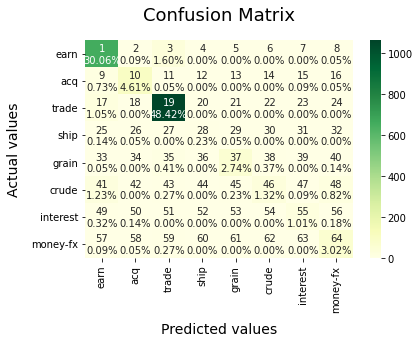

In [ ]:
model_Evaluate(model)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB

In [ ]:
lg = LogisticRegression(max_iter=200)
lg.fit(Xtrain, Ytrain)
model_Evaluate(lg)

Accuracy of model on training data : 93.19424751873608
Accuracy of model on testing data : 92.64504339881225 

              precision    recall  f1-score   support

         acq       0.94      0.93      0.93       696
       crude       0.89      0.88      0.89       121
        earn       0.96      0.98      0.97      1083
       grain       1.00      0.50      0.67        10
    interest       0.88      0.78      0.82        81
    money-fx       0.73      0.61      0.66        87
        ship       0.71      0.67      0.69        36
       trade       0.77      0.91      0.83        75

    accuracy                           0.93      2189
   macro avg       0.86      0.78      0.81      2189
weighted avg       0.93      0.93      0.93      2189

[[ 647    3   42    0    0    1    1    2]
 [  10  107    0    0    0    0    4    0]
 [  19    1 1061    0    1    1    0    0]
 [   1    1    0    5    1    0    1    1]
 [   0    0    2    0   63   15    0    1]
 [   7    0    3    0  

In [ ]:
svm = LinearSVC()
svm.fit(Xtrain, Ytrain)
model_Evaluate(svm)

Accuracy of model on training data : 92.82965363581123
Accuracy of model on testing data : 92.46231155778895 

              precision    recall  f1-score   support

         acq       0.92      0.94      0.93       696
       crude       0.91      0.88      0.90       121
        earn       0.96      0.98      0.97      1083
       grain       1.00      0.60      0.75        10
    interest       0.78      0.83      0.80        81
    money-fx       0.76      0.47      0.58        87
        ship       0.78      0.69      0.74        36
       trade       0.79      0.91      0.84        75

    accuracy                           0.92      2189
   macro avg       0.86      0.79      0.81      2189
weighted avg       0.92      0.92      0.92      2189

[[ 654    3   32    0    3    2    0    2]
 [  12  107    0    0    0    1    1    0]
 [  24    1 1056    0    1    1    0    0]
 [   1    0    1    6    0    0    1    1]
 [   0    0    4    0   67    9    0    1]
 [  15    0    3    0  

In [ ]:
nb = BernoulliNB()
nb.fit(Xtrain, Ytrain)
model_Evaluate(nb)

Accuracy of model on training data : 82.17541016811829
Accuracy of model on testing data : 86.29511192325263 

              precision    recall  f1-score   support

         acq       0.90      0.87      0.88       696
       crude       0.88      0.88      0.88       121
        earn       0.93      0.94      0.94      1083
       grain       0.45      0.50      0.48        10
    interest       0.68      0.78      0.73        81
    money-fx       0.27      0.13      0.17        87
        ship       0.48      0.81      0.60        36
       trade       0.51      0.72      0.60        75

    accuracy                           0.86      2189
   macro avg       0.64      0.70      0.66      2189
weighted avg       0.86      0.86      0.86      2189

[[ 603    7   52    2    3   11   10    8]
 [   4  107    0    0    0    0    7    3]
 [  53    1 1017    0    8    3    0    1]
 [   1    2    0    5    0    1    1    0]
 [   0    0    4    0   63   10    0    4]
 [   6    0    9    3  

Accuracy of model on training data : 62.30504354871379
Accuracy of model on testing data : 52.26130653266332 

              precision    recall  f1-score   support

         acq       0.34      0.09      0.14       696
       crude       0.00      0.00      0.00       121
        earn       0.54      1.00      0.70      1083
       grain       0.00      0.00      0.00        10
    interest       1.00      0.01      0.02        81
    money-fx       0.00      0.00      0.00        87
        ship       0.00      0.00      0.00        36
       trade       0.00      0.00      0.00        75

    accuracy                           0.52      2189
   macro avg       0.23      0.14      0.11      2189
weighted avg       0.41      0.52      0.39      2189

[[  61    0  635    0    0    0    0    0]
 [  18    0  102    0    0    0    0    1]
 [   1    0 1082    0    0    0    0    0]
 [   0    0   10    0    0    0    0    0]
 [   2    0   78    0    1    0    0    0]
 [  44    0   42    0  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


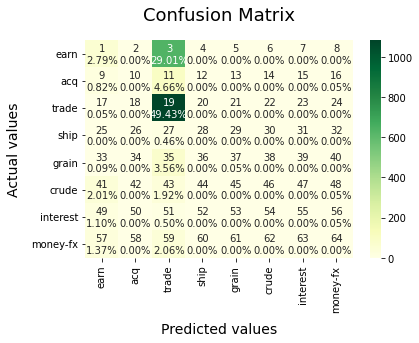

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
nb = MultinomialNB()
nb.fit(Xtrain, Ytrain)
model_Evaluate(nb)

In [ ]:
Xtrain

array([[-0.06725247,  0.08539572,  0.2263566 , ...,  0.17827554,
         0.0833132 ,  0.11637872],
       [ 0.18510444,  0.03316248,  0.25921196, ...,  0.17746709,
         0.20853119,  0.11007509],
       [ 0.1849914 ,  0.06169339,  0.94369245, ...,  0.48700464,
         0.4420923 ,  0.23194163],
       ...,
       [ 0.01992667,  0.22484311,  0.48639497, ...,  0.39244089,
        -0.01524843,  0.19841908],
       [-0.03393126,  0.00610911,  0.08683188, ...,  0.01354746,
        -0.0202043 ,  0.20842768],
       [ 0.21429469,  0.05137479,  0.39676014, ...,  0.47287098,
         0.05017794,  0.14598998]])

In [ ]:
y_pred = model.predict(Xtest)
cf_matrix = confusion_matrix(Ytest, y_pred)

cf_matrix.flatten()

array([ 656,    2,   37,    0,    0,    0,    0,    1,   16,  102,    1,
          0,    0,    0,    1,    1,   21,    0, 1062,    0,    0,    0,
          0,    0,    2,    1,    1,    4,    1,    0,    0,    1,    0,
          0,    9,    0,   59,   10,    0,    3,   26,    0,    6,    0,
          5,   29,    1,   20,    6,    4,    0,    0,    0,    0,   22,
          4,    3,    1,    4,    0,    0,    1,    0,   66])

In [ ]:
list(Ytrain.unique())

['earn', 'acq', 'trade', 'ship', 'grain', 'crude', 'interest', 'money-fx']

In [ ]:
Ytest.value_counts()

earn        1083
acq          696
crude        121
money-fx      87
interest      81
trade         75
ship          36
grain         10
Name: intent, dtype: int64

In [ ]:
sum([len(i.split()) for i in train.text.values])/train.shape[0]

66.31557626088718

In [ ]:
train.text.values

array(['champion product approv stock split champion product inc board director approv two for stock split common share for sharehold record april compani board vote recommend sharehold annual meet april increas author capit stock mln mln share reuter',
       'comput termin system cpml complet sale comput termin system inc complet sale share common stock and warrant acquir addit mln share sedio lugano switzerland for dlr compani warrant exercis for year purchas price dlr per share comput termin sedio bui addit share and increas total hold pct comput termin outstand common stock circumst involv chang control compani compani condit occur warrant exercis price equal pct common stock market price time not exce dlr per share comput termin sold technolgi right dot matrix impact technolog includ futur improv woodco inc houston tex for dlr continu exclus worldwid license technolog for woodco compani move part reorgan plan and pai current oper cost and ensur product deliveri comput termin make

In [ ]:
train.shape[0]

4937

In [ ]:
train['sent_len'] = train.text.apply(lambda x: len(x.split()))

In [ ]:
train

text  \
0     champion product approv stock split champion p...   
1     comput termin system cpml complet sale comput ...   
2     cobanco inc cbco year net shr ct dlr net asset...   
3     intern inc qtr jan oper shr loss two ct profit...   
4     brown forman inc bfd qtr net shr dlr ct net ml...   
...                                                 ...   
4932  equicor see year revenu top two billion equico...   
4933  macandrew forb begin revlon rev offer macandre...   
4934  arco arc higher earn estim atlant richfield st...   
4935  deak intern bui johnson matthei deak intern fo...   
4936  wall street stock purol courier pcc purol cour...   

                                                   edge intent  sent_len  
0     champion product approv stock split champion p...   earn        37  
1     comput termin system cpml complet sale comput ...    acq       128  
2     cobanco inc cbco year net shr ct dlr net asset...   earn        33  
3     intern inc qtr jan oper shr loss two ct profit...   earn        70  
4     brown forman inc bfd qtr net shr dlr ct net ml...   earn        26  
...                                                 ...    ...       ...  
4932  equicor see year revenu top two billion equico...   earn        67  
4933  macandrew forb begin revlon rev offer macandre...    acq        65  
4934  arco arc higher earn estim atlant richfield st...   earn       108  
4935  deak intern bui johnson matthei deak intern fo...    acq        69  
4936  wall street stock purol courier pcc purol cour...    acq        54  

[4937 rows x 4 columns]

In [ ]:
len(set(train.text[1].split()))

79